In [8]:
import matplotlib
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
xs = [
8,
16,
32,
64,
128,
256,
512,
1024,
2048,
4096,
8192,
16384,
32768
]

#Data used in Cluster submission
'''
o_dev_hbm = [
10.59936,
10.04872,
10.14744,
10.17488,
10.29976,
10.00952,
10.03904,
10.05808,
10.47616,
10.53232,
11.06464,
11.58928,
12.50856
]

#Format for Cluster submission
o_host_hbm = [
1.869359995,
1.468719995,
1.467439995,
1.364879995,
1.459759995,
1.549519995,
1.529039995,
1.588079995,
1.706159995,
1.842319995,
2.814639995,
3.359279995,
4.048559995
]

o_host_hbm_kern = [y+5 for y in o_host_hbm]

o_host_dram = [
1.249359995,
1.248719995,
1.247439995,
1.254879995,
1.279759995,
1.319519995,
1.349039995,
1.428079995,
1.826159995,
2.112319995,
2.494639995,
2.979279995,
3.758559995
]
'''

#From Spreadsheet
NV_HI_get_O = [
-0.00064,
-0.01128,
0.01244,
-0.00512,
0.00476,
0.02452,
0.04904,
0.04308,
0.34116,
0.35232,
0.49964,
0.41928,
0.06356,
]

NV_HI_put_O = [
-0.00128,
-0.02256,
-0.02512,
0.00976,
-0.01048,
0.00904,
0.00808,
0.02616,
0.08232,
0.12464,
0.65928,
0.57856,
0.01712
]

In [9]:
def SST(samples):
    y_bar = 0
    for x, y_i in samples:
        y_bar += y_i
    y_bar /= len(samples)
    tmp = 0
    for x, y_i in samples:
        tmp += (y_i - y_bar)**2
    return tmp

def SSReg(samples, pipelined=False):
    y_bar = 0
    for x, y_i in samples:
        y_bar += y_i
    y_bar /= len(samples)
    tmp = 0
    for x, y_i in samples:
        if pipelined:
            tmp += ((timeToGetMessageSummitPipelined(x*4, 'h')*2)/1e9 - y_bar)**2
        else:
            tmp += ((timeToGetMessageSummit(x*4, 'h')*2)/1e9 - y_bar)**2
    return tmp

def SSRes(samples, pipelined=False):
    tmp = 0
    for x, y_i in samples:
        if pipelined:
            tmp += ((timeToGetMessageSummitPipelined(x*4, 'h')*2)/1e9 - y_i)**2
        else:
            tmp += ((timeToGetMessageSummit(x*4, 'h')*2)/1e9 - y_i)**2
        #print("diff b/n model and sample {} - {} = {}".format(
        #(timeToGetMessageSummit(x*4, 'h')*2)/1e9, y_i, (timeToGetMessageSummit(x*4, 'h')*2)/1e9 - y_i ))
    return tmp



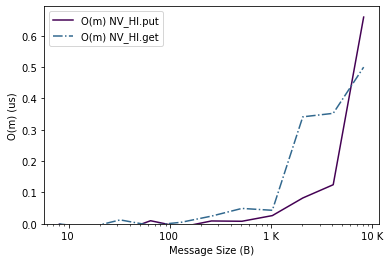

In [21]:
matplotlib.rc('image', cmap='viridis')

xs = [
8,
16,
32,
64,
128,
256,
512,
1024,
2048,
4096,
8192,
16384,
32768
]

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

import matplotlib.pylab as pl

n = 4
colors = pl.cm.viridis(np.linspace(0,1,n))


fig, ax = plt.subplots()

#Only going to 8k before we see gap taking over.
xs = xs[:-2]
labels=("O(m) NV_HI.put", "O(m) NV_HI.get")
lines = ('-', '-.')
data = {
    "NV_HI_put_O":NV_HI_put_O[:-2], 
    "NV_HI_get_O":NV_HI_get_O[:-2]
}
color = 0
for series in data.keys():
    ys = data[series]
    ax.plot(xs,ys, color=colors[color], ls=lines[color], label=labels[color])
    color += 1

ax.set_xscale("log")
plt.legend()
plt.viridis()
ax.set_ylabel("O(m) (us)")
ax.set_xlabel("Message Size (B)")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Pipelined, Aync. Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylim(ymin=0)
plt.show()
fig.tight_layout()
fig.savefig("OverheadHostPutvsGet.png")

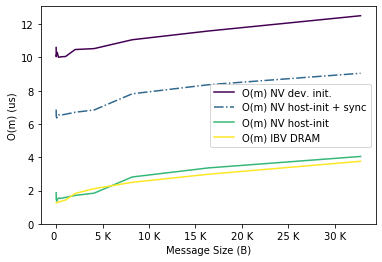

In [18]:
### PLOT FOR CLUSTER ###

matplotlib.rc('image', cmap='viridis')


def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

import matplotlib.pylab as pl

n = 4
colors = pl.cm.viridis(np.linspace(0,1,n))


fig, ax = plt.subplots()

xs = xs
labels=("O(m) NV dev. init.", "O(m) NV host-init + sync", "O(m) NV host-init", "O(m) IBV DRAM",)
lines = ('-', '-.', '-', '-')
data = {
    "o_dev_hbm":o_dev_hbm, 
    "o_host_hbm_kern":o_host_hbm_kern,
    "o_host_hbm":o_host_hbm,  
    "o_host_dram":o_host_dram
}
color = 0
for series in data.keys():
    ys = data[series]
    ax.plot(xs,ys, color=colors[color], ls=lines[color], label=labels[color])
    color += 1

#ax.set_xscale("log")
plt.legend()
plt.viridis()
ax.set_ylabel("O(m) (us)")
ax.set_xlabel("Message Size (B)")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Pipelined, Aync. Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylim(ymin=0)
plt.show()
fig.tight_layout()
fig.savefig("OverheadDevVsHost.png")

In [ ]:
model_ys

In [ ]:
xs